# Import Package

In [ ]:
#Import module yang dibutuhkan
from statsmodels.graphics import utils
from statsmodels.compat.python import lrange, lzip

#membuat plot residual
def _influence_plot(results, influence, external=True, alpha=.05,
                    criterion="cooks", size=48, plot_alpha=.75, ax=None,
                    leverage=None, resid=None,
                    **kwargs):
    # leverage and resid kwds are used only internally for MLEInfluence
    infl = influence
    fig, ax = utils.create_mpl_ax(ax)

    if criterion.lower().startswith('coo'):
        psize = infl.cooks_distance[0]
    elif criterion.lower().startswith('dff'):
        psize = np.abs(infl.dffits[0])
    else:
        raise ValueError("Criterion %s not understood" % criterion)

    # scale the variables
    #TODO: what is the correct scaling and the assumption here?
    #we want plots to be comparable across different plots
    #so we would need to use the expected distribution of criterion probably
    old_range = np.ptp(psize)
    new_range = size**2 - 8**2

    psize = (psize - psize.min()) * new_range/old_range + 8**2

    if leverage is None:
        leverage = infl.hat_matrix_diag
    if resid is None:
        ylabel = "Studentized Residuals"
        if external:
            resid = infl.resid_studentized_external
        else:
            resid = infl.resid_studentized
    else:
        resid = np.asarray(resid)
        ylabel = "Residuals"

    from scipy import stats #mengimport module yang dibutuhkan
    #melakukan perhitungan
    cutoff = stats.t.ppf(1.-alpha/2, results.df_resid)
    large_resid = np.abs(resid) > cutoff
    large_leverage = leverage > _high_leverage(results)
    large_points = np.logical_or(large_resid, large_leverage)

    ax.scatter(leverage, resid, s=psize, alpha=plot_alpha)

    # add point labels
    labels = results.model.data.row_labels
    if labels is None:
        labels = lrange(len(resid))

    # TODO: make configurable or let people do it ex-post?
    font = {"fontsize": 16, "color": "black"}
    ax.set_ylabel(ylabel, **font)
    ax.set_xlabel("Leverage", **font)
    ax.set_title("Influence Plot", **font)
    return fig

def influence_plot(results, external=True, alpha=.05, criterion="cooks",
                   size=48, plot_alpha=.75, ax=None, **kwargs):

  infl = results.get_influence()
  res = _influence_plot(results, infl, external=external, alpha=alpha,
                        criterion=criterion, size=size,
                        plot_alpha=plot_alpha, ax=ax, **kwargs)
  return res

def _high_leverage(results):
    #TODO: replace 1 with k_constant
    return 2. * (results.df_model + 1)/results.nobs

In [ ]:
# Custom function for regression analysis
def Plotmaker(MLR):
  # Create a 2x2 grid for the plots
  fig, axes = plt.subplots(2, 2, figsize=(8, 6))

  # Influence Plot
  influence_plot(MLR, ax=axes[0, 0], size=2)
  axes[0, 0].set_title("Influence Plot")

  # Normal Q-Q Plot
  sm.qqplot(MLR.resid, line='s', ax=axes[0, 1])
  axes[0, 1].set_title("Normal Q-Q Plot")

  # Residuals vs. Fitted Values Plot
  axes[1, 0].scatter(MLR.fittedvalues, MLR.resid, s=5)
  axes[1, 0].set_title("Residuals vs. Fitted Values Plot")
  axes[1, 0].set_xlabel("Fitted Values")
  axes[1, 0].set_ylabel("Residuals")

  # Scale-Location Plot
  axes[1, 1].scatter(MLR.fittedvalues, abs(stats.zscore(MLR.resid)), c='red', s=5)
  axes[1, 1].set_title("Scale-Location Plot")
  axes[1, 1].set_xlabel("Fitted Values")
  axes[1, 1].set_ylabel("Standardized Residuals (Absolute Value)")

  plt.tight_layout()
  return plt.show() #menampilkan plot

In [ ]:
!pip install catboost lightgbm

#Import module yang dibutuhkan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Import Data

In [ ]:
!gdown 1JTem3RrR0BRd4FlhFI6K74ERs2D4fwLh
!gdown 1a2AMg1xfOjNg2exBvJAar3RJQmWWEzK0

Downloading...
From: https://drive.google.com/uc?id=1JTem3RrR0BRd4FlhFI6K74ERs2D4fwLh
To: /content/train.csv
100% 400k/400k [00:00<00:00, 42.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a2AMg1xfOjNg2exBvJAar3RJQmWWEzK0
To: /content/test.csv
100% 91.5k/91.5k [00:00<00:00, 9.59MB/s]


# Data

In [ ]:
# Baca file CSV ke dalam DataFrame
df = pd.read_csv('train.csv')

# Tampilkan beberapa baris pertama data
df.head()

,id,"Alkalinity, total",Calcium,Chloride,Fluoride,Magnesium,Nitrate as N,Sodium,Specific Conductivity,Sulfate,Total Dissolved Solids,Hardness
0,0,120.0,24.0,6.9,0.314,7.1,0.498,48.0,510.0,23.2,240.0,90.4
1,1,140.0,41.0,11.0,0.150,6.5,0.950,19.0,300.0,8.5,190.0,130.0
2,2,160.0,51.0,9.0,0.450,9.1,2.500,12.0,370.0,25.0,230.0,160.0
3,3,46.0,13.0,2.9,0.120,2.7,0.430,6.4,110.0,5.0,97.0,41.0
4,4,240.0,147.0,70.0,0.600,48.0,6.800,93.0,1410.0,418.0,950.0,586.0


In [ ]:
# Menghitung persentil 75 Sodium
sodium_75th_percentile = df['Sodium'].quantile(0.75)

# Memfilter data dengan memilih baris yang memiliki sodium di atas persentil 75 sodium dan alkalinity di atas rata-rata
filtered_data = df[(df['Sodium'] > sodium_75th_percentile) & (df['Alkalinity, total'] > df['Alkalinity, total'].mean())]

# Menghitung rata-rata hardness dari data yang sudah di filter
average_hardness = filtered_data['Hardness'].mean()

print("Persentil 75 Sodium:", sodium_75th_percentile)
print("Rata-rata Alkalinity:", df['Alkalinity, total'].mean())
print("Data yang sudah di filter:")
print(filtered_data)
print("Hardness rata-rata dari sumber air yang memiliki kadar sodium di atas persentil 75 dan memiliki tingkat kebasaan (Alkalinity) di atas rata-rata:", average_hardness)

Persentil 75 Sodium: 60.0
Rata-rata Alkalinity: 167.151046875
Data yang sudah di filter:
        id  Alkalinity, total  Calcium  Chloride  Fluoride  Magnesium  \
4        4              240.0   147.00      70.0      0.60     48.000   
9        9              256.0    77.67     120.0      0.16     28.990   
12      12              280.0    90.00      31.0      2.10     37.000   
13      13              190.0    69.00     240.0      0.94      6.200   
18      18              242.0    98.10     138.0      0.40     30.300   
...    ...                ...      ...       ...       ...        ...   
6377  6377              180.0   130.00     420.0      0.11     49.000   
6390  6390              230.0   110.00     130.0      0.31     37.013   
6391  6391              170.0    45.00      54.0      0.62     11.000   
6394  6394              240.0   135.00      57.0      0.70     47.000   
6398  6398              210.0   110.00     190.0      0.23     47.000   

      Nitrate as N  Sodium  Specif

# Preprocessing Data dan EDA

In [ ]:
df.info() #melihat informasi detail mengenai data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6400 non-null   int64  
 1   Alkalinity, total       6400 non-null   float64
 2   Calcium                 6400 non-null   float64
 3   Chloride                6400 non-null   float64
 4   Fluoride                6400 non-null   float64
 5   Magnesium               6400 non-null   float64
 6   Nitrate as N            6400 non-null   float64
 7   Sodium                  6400 non-null   float64
 8   Specific Conductivity   6400 non-null   float64
 9   Sulfate                 6400 non-null   float64
 10  Total Dissolved Solids  6400 non-null   float64
 11  Hardness                6400 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 600.1 KB


In [ ]:
df.describe().transpose() #mentranspose data

,count,mean,std,min,25%,50%,75%,max
id,6400.0,3199.500000,1847.665193,0.0000,1599.75,3199.50,4799.25000,6399.0
"Alkalinity, total",6400.0,167.151047,83.157803,12.0000,110.00,153.50,209.00000,1000.0
Calcium,6400.0,69.350432,1052.136452,0.6100,25.00,45.00,72.00000,83000.0
Chloride,6400.0,53.213620,92.934505,0.5800,11.00,28.00,62.00000,2100.0
Fluoride,6400.0,0.333625,0.452473,0.0490,0.14,0.21,0.38225,9.0
Magnesium,6400.0,23.446335,325.389503,0.0510,7.30,14.00,25.00000,26000.0
Nitrate as N,6400.0,3.382707,4.878279,0.0023,0.85,2.00,4.30000,106.0
Sodium,6400.0,62.437731,556.891904,1.3000,21.00,35.00,60.00000,32000.0
Specific Conductivity,6400.0,637.631953,597.297274,40.0000,340.00,520.00,800.00000,31400.0
Sulfate,6400.0,71.645934,108.414049,0.1400,13.00,33.00,85.00000,2000.0


## Missing Value

In [ ]:
#Syntax buat melihat jumlah missing value pada data
missing_values = df.isnull().sum()

# Melihat proporsi missing values per kolom (dalam persentase)
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Menyusun data ke dalam DataFrame untuk ditampilkan
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

# Menampilkan DataFrame yang berisi informasi tentang missing values
print(missing_info)

                        Missing Values  Percentage
id                                   0         0.0
Alkalinity, total                    0         0.0
Calcium                              0         0.0
Chloride                             0         0.0
Fluoride                             0         0.0
Magnesium                            0         0.0
Nitrate as N                         0         0.0
Sodium                               0         0.0
Specific Conductivity                0         0.0
Sulfate                              0         0.0
Total Dissolved Solids               0         0.0
Hardness                             0         0.0


## Outlier (Tidak Dihapus)

### Metode Kuartil

In [ ]:
df_unfiltered = df #mendefinisikan df (data yang telah dihapus missing value) menjadi df_unfiltered
#Identify outliers using interquartile range
##Inter-Quartile Range based outlier removal
df_num_features=df.select_dtypes(include=np.number)
Q1 = df_num_features.quantile(0.25) #mencari quantile 0,25
Q3 = df_num_features.quantile(0.75) #mencari quantile 0,75
IQR = Q3 - Q1 #mendefinisikan IQR dengan Q3 - Q1
print(IQR) #menampilkan IQR

id                        3199.50000
Alkalinity, total           99.00000
Calcium                     47.00000
Chloride                    51.00000
Fluoride                     0.24225
Magnesium                   17.70000
Nitrate as N                 3.45000
Sodium                      39.00000
Specific Conductivity      460.00000
Sulfate                     72.00000
Total Dissolved Solids     280.00000
Hardness                   180.00000
dtype: float64


In [ ]:
#menghitung banyaknya outlier per variabel
outlier = pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column id are 0
Total number of Outliers in column Alkalinity, total are 174
Total number of Outliers in column Calcium are 196
Total number of Outliers in column Chloride are 463
Total number of Outliers in column Fluoride are 425
Total number of Outliers in column Magnesium are 380
Total number of Outliers in column Nitrate as N are 378
Total number of Outliers in column Sodium are 492
Total number of Outliers in column Specific Conductivity are 278
Total number of Outliers in column Sulfate are 567
Total number of Outliers in column Total Dissolved Solids are 354
Total number of Outliers in column Hardness are 232


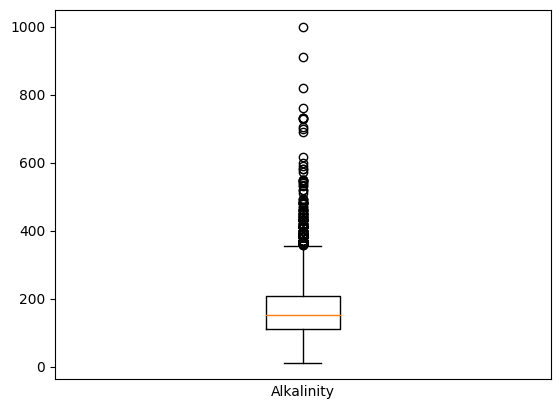

In [ ]:
# Boxplot untuk variabel alkalin
plt.boxplot(df['Alkalinity, total'])
plt.xlabel('Alkalinity')
plt.xticks([])
plt.show()

## Ganti Nama Kolom

Untuk mempermudah pengetikan code

In [ ]:
# Ganti Nama Kolom
df.columns = ['id', 'alkalin','calcium','chloride', 'fluoride',	'magnesium', 'nitrate', 'sodium', 'conductivity', 'sulfate', 'dissolved',	'hardness']

## Hapus kolom "id"

In [ ]:
# Hapus kolom 'id'
df = df.drop(["id"], axis=1)

## Multikolinearitas

### Data sebelum hapus outlier

In [ ]:
#mendefinisikan y, x_numerical, dan x_categorical
y = df['hardness']
x_numerical = df[['alkalin','calcium','chloride', 'fluoride',	'magnesium', 'nitrate', 'sodium', 'conductivity', 'sulfate', 'dissolved']]

[Text(0.5, 1.0, 'Numerical Data Heatmap')]

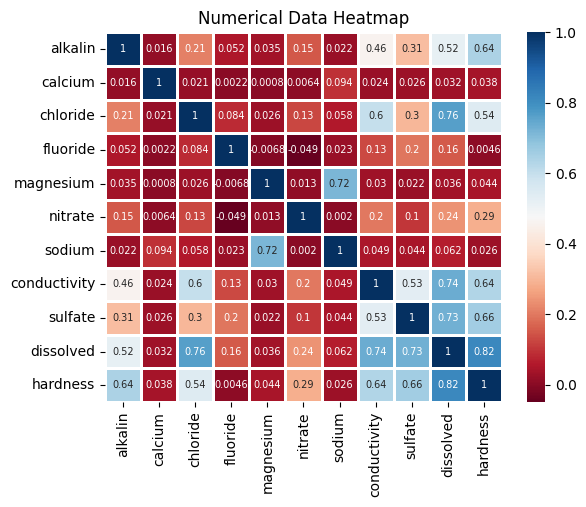

In [ ]:
#memvisualisasikan dalam bentuk heatmap buat data numerik
plt.figure(dpi=100)
sns.heatmap(pd.concat([x_numerical, y], axis=1).corr(), linewidths=1, cmap="RdBu", annot=True, annot_kws={'size':7}).set(title='Numerical Data Heatmap') #memvisualisasikan dalam bentuk heatmap

In [ ]:
#Multicolinearity test
#Akan dihitungn VIF pada data numerik
test = x_numerical
test = sm.add_constant(test)
vif_data = pd.DataFrame()
vif_data["Variable"] = test.columns  #memmuculkan Variable dalam 1 kolom
vif_data["VIF"] = [variance_inflation_factor(test.values, i) for i in range(test.shape[1])] #memmuculkan hasil perhitungan VIF dalam 1 kolom
vif_data #menampilkan hasil perhitungan

,Variable,VIF
0,const,6.013753
1,alkalin,1.931052
2,calcium,1.018911
3,chloride,5.125880
4,fluoride,1.049024
5,magnesium,2.084729
6,nitrate,1.140907
7,sodium,2.108107
8,conductivity,2.324562
9,sulfate,4.024224


### Data setelah hapus outlier

In [ ]:
# Hitung Q1 (kuartil pertama) dan Q3 (kuartil ketiga) untuk setiap kolom
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Hitung IQR (Interquartile Range) untuk setiap kolom
IQR = Q3 - Q1

# Tentukan batas bawah dan batas atas
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outlier
df_filtered = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df_filtered.reset_index(inplace=True, drop=True)

df_filtered

,alkalin,calcium,chloride,fluoride,magnesium,nitrate,sodium,conductivity,sulfate,dissolved,hardness
0,120.0,24.0,6.9,0.314,7.1,0.498,48.0,510.0,23.20,240.0,90.4
1,140.0,41.0,11.0,0.150,6.5,0.950,19.0,300.0,8.50,190.0,130.0
2,160.0,51.0,9.0,0.450,9.1,2.500,12.0,370.0,25.00,230.0,160.0
3,46.0,13.0,2.9,0.120,2.7,0.430,6.4,110.0,5.00,97.0,41.0
4,154.0,49.2,51.0,0.250,10.6,0.550,51.7,619.0,100.00,338.0,198.0
...,...,...,...,...,...,...,...,...,...,...,...
4680,115.0,27.9,14.9,0.100,9.2,2.900,21.0,292.0,4.10,217.0,113.0
4681,180.0,58.0,40.0,0.180,25.0,3.600,22.0,540.0,48.00,400.0,219.0
4682,44.0,5.7,3.0,0.120,3.7,0.470,5.9,100.0,0.85,56.0,30.0
4683,138.0,40.3,28.4,0.100,14.2,8.600,31.0,438.0,17.70,300.0,159.0


In [ ]:
#mendefinisikan y, x_numerical, dan x_categorical
y = df_filtered['hardness']
x_numerical = df_filtered[['alkalin','calcium','chloride', 'fluoride',	'magnesium', 'nitrate', 'sodium', 'conductivity', 'sulfate', 'dissolved']]

[Text(0.5, 1.0, 'Numerical Data Heatmap')]

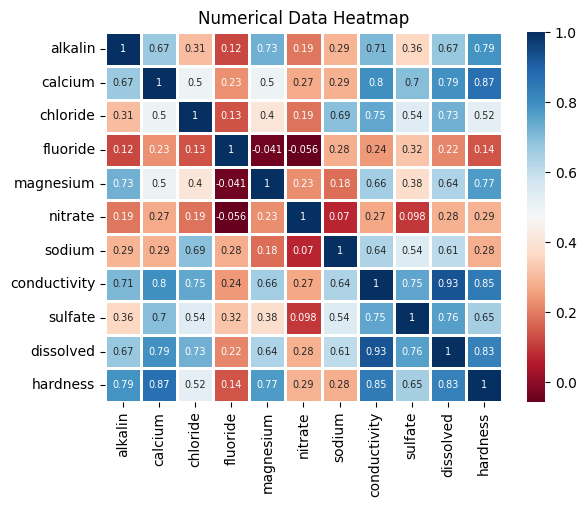

In [ ]:
#memvisualisasikan dalam bentuk heatmap buat data numerik
plt.figure(dpi=100)
sns.heatmap(pd.concat([x_numerical, y], axis=1).corr(), linewidths=1, cmap="RdBu", annot=True, annot_kws={'size':7}).set(title='Numerical Data Heatmap') #memvisualisasikan dalam bentuk heatmap

In [ ]:
#Multicolinearity test
#Akan dihitungn VIF pada data numerik
test = x_numerical
test = sm.add_constant(test)
vif_data = pd.DataFrame()
vif_data["Variable"] = test.columns  #memmuculkan Variable dalam 1 kolom
vif_data["VIF"] = [variance_inflation_factor(test.values, i) for i in range(test.shape[1])] #memmuculkan hasil perhitungan VIF dalam 1 kolom
vif_data #menampilkan hasil perhitungan

,Variable,VIF
0,const,11.793563
1,alkalin,5.594056
2,calcium,6.181289
3,chloride,4.380790
4,fluoride,1.231532
5,magnesium,3.693461
6,nitrate,1.218120
7,sodium,4.137256
8,conductivity,13.615178
9,sulfate,4.585158


## Mutual Information

Data yang digunakan adalah data DENGAN outlier

In [ ]:
X = df.copy()
y = X.pop("hardness")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

calcium         0.976494
conductivity    0.832349
dissolved       0.770053
magnesium       0.723504
alkalin         0.554498
sulfate         0.430362
chloride        0.286644
sodium          0.168909
nitrate         0.085667
fluoride        0.063392
Name: MI Scores, dtype: float64

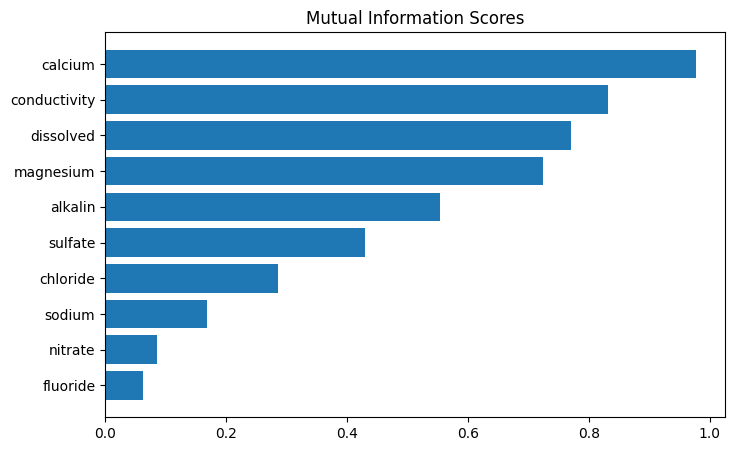

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Penambahan Variabel

In [ ]:
# Menambahkan kolom-kolom baru berdasarkan variabel-variabel yang diusulkan

# 1. Total Cations
df['Total_Cations'] = df['calcium'] + df['magnesium'] + df['sodium']

# 2. Ca/Mg Ratio
df['Ca_Mg_Ratio'] = df['calcium'] / df['magnesium']

# 3. Total Ions
df['Total_Ions'] = df['calcium'] + df['magnesium'] + df['sodium'] + df['chloride'] + df['sulfate'] + df['nitrate'] + df['fluoride']

# 4. Sulfate/Chloride Ratio
df['Sulfate_Chloride_Ratio'] = df['sulfate'] / df['chloride']

# 5. Conductivity to Total Dissolved Solids Ratio
df['Conductivity_TDS_Ratio'] = df['conductivity'] / df['dissolved']

# 6. Alkalinity to Conductivity Ratio
df['Alkalinity_Conductivity_Ratio'] = df['alkalin'] / df['conductivity']

# 7. Total Divalent Cations
df['Total_Divalent_Cations'] = df['calcium'] + df['magnesium']

# 8. Alkalinity to Total Cations Ratio
df['Alkalinity_Cations_Ratio'] = df['alkalin'] / df['Total_Cations']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alkalin                        6400 non-null   float64
 1   calcium                        6400 non-null   float64
 2   chloride                       6400 non-null   float64
 3   fluoride                       6400 non-null   float64
 4   magnesium                      6400 non-null   float64
 5   nitrate                        6400 non-null   float64
 6   sodium                         6400 non-null   float64
 7   conductivity                   6400 non-null   float64
 8   sulfate                        6400 non-null   float64
 9   dissolved                      6400 non-null   float64
 10  hardness                       6400 non-null   float64
 11  Total_Cations                  6400 non-null   float64
 12  Ca_Mg_Ratio                    6400 non-null   f

### Mutual Information Setelah Penambahan Var

In [ ]:
X = df.copy()
y = X.pop("hardness")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Total_Divalent_Cations           1.646490
calcium                          0.978044
conductivity                     0.826224
Total_Cations                    0.799019
dissolved                        0.768169
magnesium                        0.732218
Total_Ions                       0.639733
alkalin                          0.561338
sulfate                          0.440571
chloride                         0.284345
sodium                           0.177095
Alkalinity_Conductivity_Ratio    0.132202
Ca_Mg_Ratio                      0.123336
Alkalinity_Cations_Ratio         0.114785
nitrate                          0.087529
Conductivity_TDS_Ratio           0.072936
fluoride                         0.048965
Sulfate_Chloride_Ratio           0.048331
Name: MI Scores, dtype: float64

Variabel ini selanjutnya TIDAK akan dipakai dalam model building:

Alkalinity_Conductivity_Ratio   

Ca_Mg_Ratio                      

Alkalinity_Cations_Ratio         

Conductivity_TDS_Ratio           

Sulfate_Chloride_Ratio         

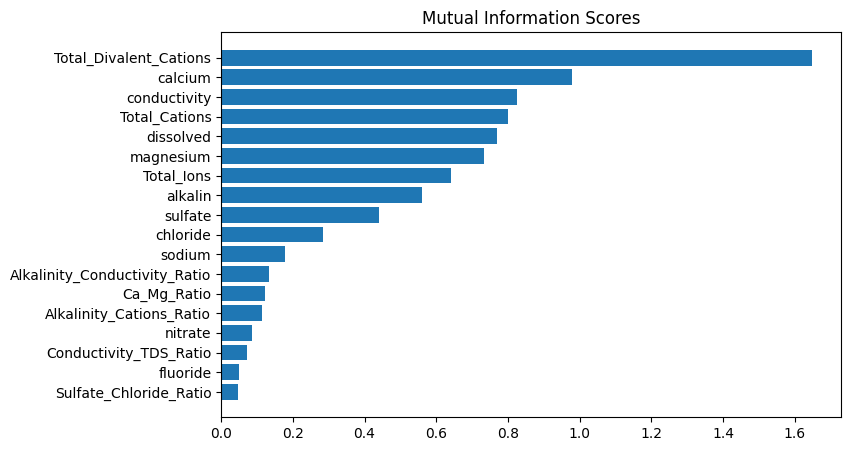

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## df_raw = df

In [ ]:
df_raw = df
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   alkalin                        6400 non-null   float64
 1   calcium                        6400 non-null   float64
 2   chloride                       6400 non-null   float64
 3   fluoride                       6400 non-null   float64
 4   magnesium                      6400 non-null   float64
 5   nitrate                        6400 non-null   float64
 6   sodium                         6400 non-null   float64
 7   conductivity                   6400 non-null   float64
 8   sulfate                        6400 non-null   float64
 9   dissolved                      6400 non-null   float64
 10  hardness                       6400 non-null   float64
 11  Total_Cations                  6400 non-null   float64
 12  Ca_Mg_Ratio                    6400 non-null   f

# Model Building

Tidak hapus outlier, hapus beberapa variabel dari feature engineering (yang telah ditentukan sebelumnya), yakni

Alkalinity_Conductivity_Ratio   

Ca_Mg_Ratio                      

Alkalinity_Cations_Ratio         

Conductivity_TDS_Ratio          

Sulfate_Chloride_Ratio           

Steps involved in Model Building

Setting up features and target

Build a pipeline of standard scalar and model for five different regressors.

Fit all the models on training data

Get mean of cross-validation on the training set for all the models for negative root mean square error

Pick the model with the best cross-validation score


In [ ]:
# Hapus 5 Variabel dari Feature Eng
data = df_raw
data.drop(columns=['Alkalinity_Conductivity_Ratio', 'Ca_Mg_Ratio', 'Alkalinity_Cations_Ratio', 'Conductivity_TDS_Ratio', 'Sulfate_Chloride_Ratio'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   alkalin                 6400 non-null   float64
 1   calcium                 6400 non-null   float64
 2   chloride                6400 non-null   float64
 3   fluoride                6400 non-null   float64
 4   magnesium               6400 non-null   float64
 5   nitrate                 6400 non-null   float64
 6   sodium                  6400 non-null   float64
 7   conductivity            6400 non-null   float64
 8   sulfate                 6400 non-null   float64
 9   dissolved               6400 non-null   float64
 10  hardness                6400 non-null   float64
 11  Total_Cations           6400 non-null   float64
 12  Total_Ions              6400 non-null   float64
 13  Total_Divalent_Cations  6400 non-null   float64
dtypes: float64(14)
memory usage: 700.1 KB


In [ ]:
# Make copy to avoid changing original data
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
label_data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,6390,6391,6392,6393,6394,6395,6396,6397,6398,6399
alkalin,120.000,140.00,160.00,46.00,240.0,154.00,110.00,120.00,220.00,256.00,...,230.000,170.00,170.0,115.0,240.0,180.00,44.00,138.0,210.00,175.00
calcium,24.000,41.00,51.00,13.00,147.0,49.20,43.00,34.00,49.00,77.67,...,110.000,45.00,130.0,27.9,135.0,58.00,5.70,40.3,110.00,63.10
chloride,6.900,11.00,9.00,2.90,70.0,51.00,52.00,18.00,52.00,120.00,...,130.000,54.00,110.0,14.9,57.0,40.00,3.00,28.4,190.00,26.80
fluoride,0.314,0.15,0.45,0.12,0.6,0.25,0.13,0.20,0.13,0.16,...,0.310,0.62,0.2,0.1,0.7,0.18,0.12,0.1,0.23,0.47
magnesium,7.100,6.50,9.10,2.70,48.0,10.60,6.70,10.00,36.00,28.99,...,37.013,11.00,42.0,9.2,47.0,25.00,3.70,14.2,47.00,11.20
nitrate,0.498,0.95,2.50,0.43,6.8,0.55,4.68,0.28,1.60,1.80,...,5.625,1.30,8.5,2.9,2.9,3.60,0.47,8.6,7.90,0.70
sodium,48.000,19.00,12.00,6.40,93.0,51.70,40.00,18.30,21.00,70.00,...,62.680,78.00,60.0,21.0,87.0,22.00,5.90,31.0,120.00,37.60
conductivity,510.000,300.00,370.00,110.00,1410.0,619.00,430.00,330.00,590.00,849.00,...,1200.000,760.00,1100.0,292.0,1410.0,540.00,100.00,438.0,1400.00,518.00
sulfate,23.200,8.50,25.00,5.00,418.0,100.00,15.00,33.30,42.00,71.00,...,110.000,32.00,150.0,4.1,426.0,48.00,0.85,17.7,140.00,57.60
dissolved,240.000,190.00,230.00,97.00,950.0,338.00,280.00,200.00,470.00,540.00,...,710.000,390.00,850.0,217.0,1000.0,400.00,56.00,300.0,800.00,306.00


Data Train 80%

In [ ]:
# Assigning the featurs as X and target as y
X= label_data.drop(["hardness"],axis =1)
y= label_data["hardness"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=7)

In [ ]:
# Building pipelines of standard scaler and model for various regressors
random = 82
pipeline_lr = Pipeline([("scalar1", StandardScaler()), ("lr_classifier", LinearRegression())])

pipeline_dt = Pipeline([("scalar2", StandardScaler()), ("dt_classifier", DecisionTreeRegressor(random_state=random))])

pipeline_rf = Pipeline([("scalar3", StandardScaler()), ("rf_classifier", RandomForestRegressor(random_state=random))])

pipeline_kn = Pipeline([("scalar4", StandardScaler()), ("kn_classifier", KNeighborsRegressor())])  # No random state for KNeighbors

pipeline_xgb = Pipeline([("scalar5", StandardScaler()), ("xgb_classifier", XGBRegressor(random_state=random))])

pipeline_gb = Pipeline([("scalar6", StandardScaler()), ("gb_classifier", GradientBoostingRegressor(random_state=random))])

pipeline_et = Pipeline([("scalar7", StandardScaler()), ("et_classifier", ExtraTreesRegressor(random_state=random))])

pipeline_cat = Pipeline([("scalar8", StandardScaler()), ("cat_classifier", CatBoostRegressor(silent=True, random_state=random))])

pipeline_lgbm = Pipeline([("scalar9", StandardScaler()), ("lgbm_classifier", LGBMRegressor(random_state=random))])

pipeline_iso = Pipeline([("scalar10", StandardScaler()), ("iso_classifier", IsolationForest(contamination=0.1, random_state=random))])



# List of all the pipelines
pipelines = [
    pipeline_lr,
    pipeline_dt,
    pipeline_rf,
    pipeline_kn,
    pipeline_xgb,
    pipeline_gb,
    pipeline_et,
    pipeline_cat,
    pipeline_lgbm,
    pipeline_iso,
]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {
    0: "LinearRegression",
    1: "DecisionTree",
    2: "RandomForest",
    3: "KNeighbors",
    4: "XGBRegressor",
    5: "GradientBoosting",
    6: "ExtraTrees",
    7: "CatBoost",
    8: "LightGBM",
    9: "IsolationForest"
}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

# Cross-validation and evaluation
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=10)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3234
[LightGBM] [Info] Number of data points in the train set: 6272, number of used features: 13
[LightGBM] [Info] Start training from score 216.192841
LinearRegression: -512.706923 
DecisionTree: -73.142049 
RandomForest: -50.291772 
KNeighbors: -75.731293 
XGBRegressor: -51.476249 
GradientBoosting: -47.540220 
ExtraTrees: -48.030366 
CatBoost: -47.708314 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3223
[LightGBM] [Info] Number of data points in the train set: 5644, number of used features: 13
[LightGBM] [Info] Start training from score 216.347962
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
Y

## Testing pada Data X_test

In [ ]:
# Random = 82
# Model prediction and evaluation for all models
for i, model in enumerate(pipelines):
    pred = model.predict(X_test)
    print(f"Model: {pipe_dict[i]}")
    print("R^2:", metrics.r2_score(y_test, pred))
    print("Adjusted R^2:", 1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    print("MAE:", metrics.mean_absolute_error(y_test, pred))
    print("MSE:", metrics.mean_squared_error(y_test, pred))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))
    print("")  # empty line for readability

Model: LinearRegression
R^2: 0.7798490829271375
Adjusted R^2: 0.7547441537872497
MAE: 42.967631905889924
MSE: 4808.826284405132
RMSE: 69.34570126839249

Model: DecisionTree
R^2: 0.9016737522246969
Adjusted R^2: 0.8904611099345308
MAE: 28.521875
MSE: 2147.77140625
RMSE: 46.34405470230243

Model: RandomForest
R^2: 0.9517394258519537
Adjusted R^2: 0.9462360270455975
MAE: 20.605451562499997
MSE: 1054.171022993278
RMSE: 32.46799998449671

Model: KNeighbors
R^2: 0.8156243622999784
Adjusted R^2: 0.7945990702815549
MAE: 38.962778125
MSE: 4027.375513872501
RMSE: 63.4616066127584

Model: XGBRegressor
R^2: 0.9450184845957387
Adjusted R^2: 0.9387486626636737
MAE: 22.479577976465226
MSE: 1200.97867384732
RMSE: 34.655139212638

Model: GradientBoosting
R^2: 0.9550692427372955
Adjusted R^2: 0.9499455598915485
MAE: 19.321548867477905
MSE: 981.4367769888054
RMSE: 31.327891358800475

Model: ExtraTrees
R^2: 0.9554830153637142
Adjusted R^2: 0.9504065171157167
MAE: 19.289600468750002
MSE: 972.3986103159375


# Data Testing

In [ ]:
data_test = pd.read_csv('test.csv')

# Ganti Nama Kolom
data_test.columns = ['id', 'alkalin','calcium','chloride', 'fluoride',	'magnesium', 'nitrate', 'sodium', 'conductivity', 'sulfate', 'dissolved']

# Drop kolom "id"
id = data_test['id']
data_test = data_test.drop(["id"], axis=1)

# Menambahkan kolom-kolom baru berdasarkan variabel-variabel yang diusulkan
# 1. Total Cations
data_test['Total_Cations'] = data_test['calcium'] + data_test['magnesium'] + data_test['sodium']

# 2. Ca/Mg Ratio
data_test['Ca_Mg_Ratio'] = data_test['calcium'] / data_test['magnesium']

# 3. Total Ions
data_test['Total_Ions'] = data_test['calcium'] + data_test['magnesium'] + data_test['sodium'] + data_test['chloride'] + data_test['sulfate'] + data_test['nitrate'] + data_test['fluoride']

# 4. Sulfate/Chloride Ratio
data_test['Sulfate_Chloride_Ratio'] = data_test['sulfate'] / data_test['chloride']

# 5. Conductivity to Total Dissolved Solids Ratio
data_test['Conductivity_TDS_Ratio'] = data_test['conductivity'] / data_test['dissolved']

# 6. Alkalinity to Conductivity Ratio
data_test['Alkalinity_Conductivity_Ratio'] = data_test['alkalin'] / data_test['conductivity']

# 7. Total Divalent Cations
data_test['Total_Divalent_Cations'] = data_test['calcium'] + data_test['magnesium']

# 8. Alkalinity to Total Cations Ratio
data_test['Alkalinity_Cations_Ratio'] = data_test['alkalin'] / data_test['Total_Cations']


# Hapus 5 Variabel dari Feat Eng
data_test.drop(columns=['Alkalinity_Conductivity_Ratio', 'Ca_Mg_Ratio', 'Alkalinity_Cations_Ratio', 'Conductivity_TDS_Ratio', 'Sulfate_Chloride_Ratio'], inplace=True)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   alkalin                 1601 non-null   float64
 1   calcium                 1601 non-null   float64
 2   chloride                1601 non-null   float64
 3   fluoride                1601 non-null   float64
 4   magnesium               1601 non-null   float64
 5   nitrate                 1601 non-null   float64
 6   sodium                  1601 non-null   float64
 7   conductivity            1601 non-null   float64
 8   sulfate                 1601 non-null   float64
 9   dissolved               1601 non-null   float64
 10  Total_Cations           1601 non-null   float64
 11  Total_Ions              1601 non-null   float64
 12  Total_Divalent_Cations  1601 non-null   float64
dtypes: float64(13)
memory usage: 162.7 KB


### GradientBoosting

In [ ]:
pred = pipeline_gb.predict(data_test)
Hardness = pd.DataFrame(pred, columns=['Hardness'])

# Gabungkan menjadi satu DataFrame
result_df = pd.concat([id, Hardness], axis=1)

# Menyimpan DataFrame ke file CSV dengan pemisah koma
result_df.to_csv('output_gb_notallvarfteng.csv', sep=',', index=False)

result_df

,id,Hardness
0,6400,89.669837
1,6401,138.640864
2,6402,117.703007
3,6403,98.580089
4,6404,338.192704
...,...,...
1596,7996,86.919722
1597,7997,50.072447
1598,7998,186.601597
1599,7999,234.116540


# Penilaian Model

### Feature Importance

 Menunjukkan seberapa penting setiap fitur dalam membuat prediksi.

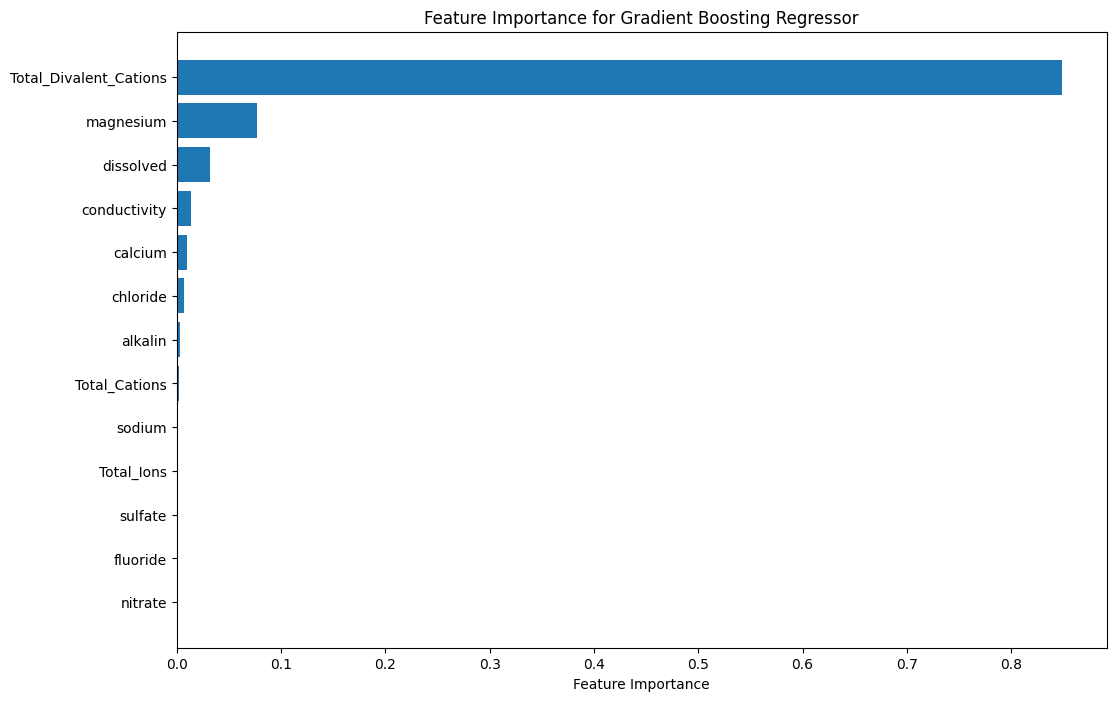

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the Gradient Boosting model
pipeline_gb.fit(X_train, y_train)

# Extract feature importances
gb_model = pipeline_gb.named_steps["gb_classifier"]
feature_importance = gb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
sorted_feature_names = X_train.columns[sorted_idx]

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names, feature_importance[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Gradient Boosting Regressor')
plt.show()


### SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations): Memberikan wawasan lebih dalam mengenai kontribusi setiap fitur pada prediksi individual. Memberikan interpretasi lebih dalam mengenai kontribusi setiap fitur untuk setiap prediksi individual, memberikan wawasan yang sangat rinci.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.6 MB/s eta 0:00:00


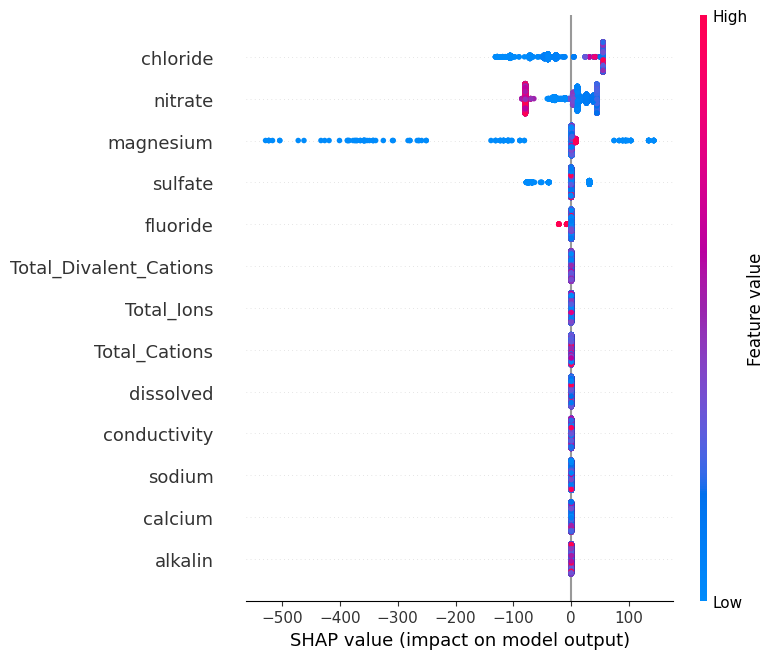

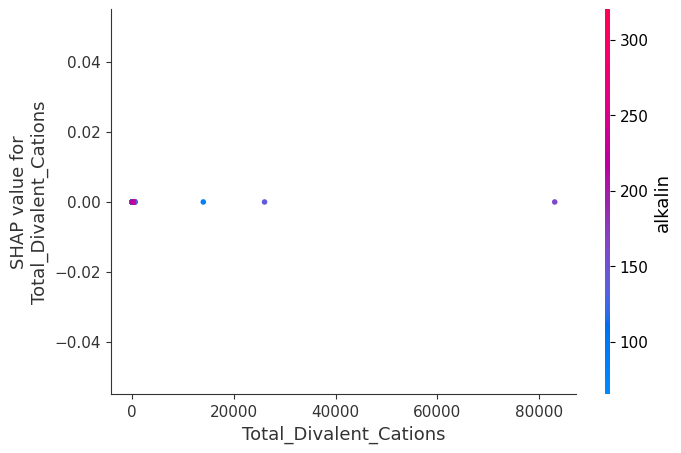

In [ ]:
import shap

# Load JS visualization library
shap.initjs()

# Initialize the explainer
explainer = shap.Explainer(gb_model, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)

# Dependence plot for the top feature
top_feature = sorted_feature_names[-1]
shap.dependence_plot(top_feature, shap_values.values, X_train)

# Force plot for a specific prediction (e.g., the first instance)
shap.force_plot(explainer.expected_value, shap_values.values[0], X_train.iloc[0])


### Tree Viz

In [ ]:
pip install graphviz pydotplus

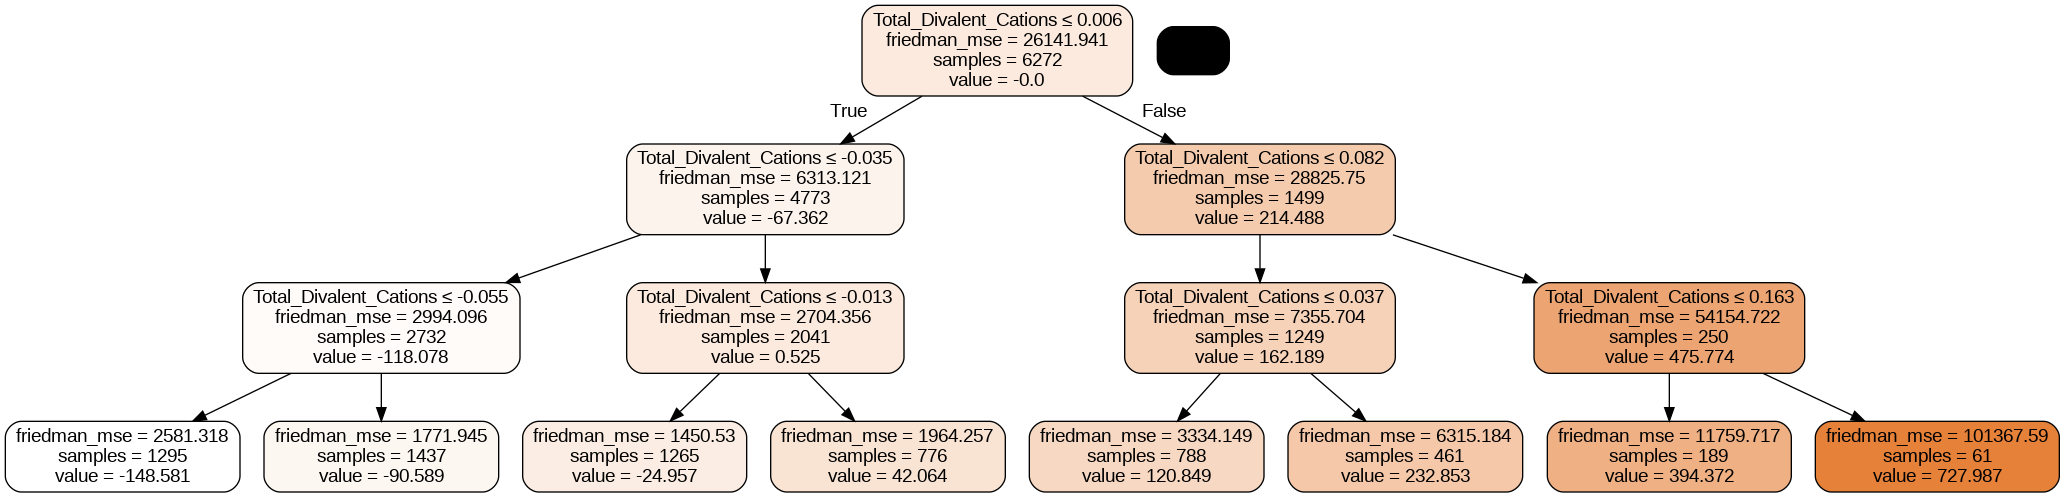

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
import graphviz

# Extract the gradient boosting model
gb_model = pipeline_gb.named_steps["gb_classifier"]

# Choose a tree to visualize (e.g., the first tree in the ensemble)
estimator = gb_model.estimators_[0, 0]

# Export the tree to a dot file
dot_data = export_graphviz(
    estimator,
    out_file=None,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    special_characters=True
)

# Convert to a graph using pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

# Show the graph
Image(graph.create_png())